In [1]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.resnet import ResNet50
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2
import os
import io

In [2]:
labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
testing_dir = 'Testing/'
training_dir = 'Training/'
image_size = 200

In [ ]:
def list_subfolders(directory):
    return [f.name for f in os.scandir(directory) if f.is_dir()]

def get_first_image_from_subfolder(subfolder_path):
    image_files = os.listdir(subfolder_path)
    if image_files:
        image_path = os.path.join(subfolder_path, image_files[0])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    return None

def display_images_from_subfolders(training_dir, subfolders):
    plt.figure(figsize=(12, 8))
    for i, subfolder in enumerate(subfolders):
        image = get_first_image_from_subfolder(os.path.join(training_dir, subfolder))
        if image is not None:
            plt.subplot(1, len(subfolders), i + 1)
            plt.title(subfolder)
            plt.axis('off')
            plt.imshow(image)
    plt.show()

In [ ]:
subfolders = list_subfolders(training_dir)
display_images_from_subfolders(training_dir, subfolders)

In [3]:
def augment_image_file(file):
    image = cv2.imread(file, 0) 
    image = cv2.bilateralFilter(image, 2, 50, 50)
    image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
    image = cv2.resize(image, (image_size, image_size))
    return image

In [4]:
def load_data(path, labels):
    X, y = [], []
    for label in labels:
        label_path = os.path.join(path, label)
        for file in os.listdir(label_path):
            image = augment_image_file(os.path.join(label_path, file))
            X.append(image)
            y.append(labels.index(label))
    return np.array(X) / 255.0, y

X_train, y_train = load_data(training_dir, labels)
X_test, y_test = load_data(testing_dir, labels)


In [5]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

y_train = to_categorical(y_train) # One-hot encoding of integer labels
y_test = to_categorical(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # 20% of the data is validation data

In [6]:
image_gen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
)

image_gen.fit(X_train)

In [7]:
resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

In [8]:
model = Model(
    inputs=resnet.input, 
    outputs=Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(
        Dropout(0.4)(
            GlobalAveragePooling2D()(resnet.output)
        )
    )
)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy', 'AUC']
)

# Display model architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [9]:
class_names = list(labels)

# Convert a matplotlib figure to a TensorFlow image tensor.
def plot_to_image(figure):
    with io.BytesIO() as buffer:
        plt.savefig(buffer, format='png')
        plt.close(figure)
        buffer.seek(0)
        digit = tf.image.decode_png(buffer.read(), channels=4)
    # Expand the dimensions so it fits the expected TF image format [1, H, W, C].
    return tf.expand_dims(digit, 0)

# Create a matplotlib plot of the confusion matrix.
def plot_confusion_matrix(cm, class_names):
    # Normalize the confusion matrix for better readability.
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    plt.colorbar()
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Add normalized values as text on the cells.
    threshold = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > threshold:
                color = 'white'
            else:
                color = 'black'
            
            text_value = "{:.2f}".format(cm_norm[i, j])
            plt.text(j, i, text_value, horizontalalignment='center', color=color)

    
    plt.tight_layout()
    return figure

# Display the confusion matrix using 
# TensorFlow summary after each epoch.
def display_conf_matrix(epoch, logs):
    # Get the model's prediction on the test data.
    pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(np.argmax(y_test, axis=1), pred)

    figure = plot_confusion_matrix(cm, class_names)
    _ = plot_to_image(figure)


In [10]:
BATCH_SIZE = 64
EPOCHS = 10

checkpoint = ModelCheckpoint(
    filepath='model.keras', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    mode='min', 
    restore_best_weights=True, 
    verbose=1
)

scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3, 
    patience=5, 
    verbose=1, 
    mode='min'
)

callbacks = [
    early_stopping, 
    scheduler, 
    checkpoint, 
    LambdaCallback(on_epoch_end=display_conf_matrix)
]

history = model.fit(
    image_gen.flow(X_train, y_train, batch_size=20),
    validation_data=(X_val, y_val), 
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
511/511 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.8871 - auc: 0.9813
Epoch 1: val_loss improved from inf to 1.86880, saving model to model.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 948s 2s/step - loss: 0.3223 - accuracy: 0.8871 - auc: 0.9813 - val_loss: 1.8688 - val_accuracy: 0.3900 - val_auc: 0.6463 - lr: 1.0000e-04
Epoch 2/10
511/511 [==============================] - ETA: 0s - loss: 0.1317 - accuracy: 0.9574 - auc: 0.9957
Epoch 2: val_loss improved from 1.86880 to 0.34465, saving model to model.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 921s 2s/step - loss: 0.1317 - accuracy: 0.9574 - auc: 0.9957 - val_loss: 0.3447 - val_accuracy: 0.9127 - val_auc: 0.9805 - lr: 1.0000e-04
Epoch 3/10
511/511 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9667 - auc: 0.9974
Epoch 3: val_loss improved from 0.34465 to 0.18716, saving model to model.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 953s 2s/step - loss: 0.1027 - accuracy: 0.9667 - auc: 0.9974 - val_loss: 0.1872 - val_accuracy: 0.9338 - val_auc: 0.9936 - lr: 1.0000e-04
Epoch 4/10
511/511 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9824 - auc: 0.9988
Epoch 4: val_loss improved from 0.18716 to 0.10186, saving model to model.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 1199s 2s/step - loss: 0.0562 - accuracy: 0.9824 - auc: 0.9988 - val_loss: 0.1019 - val_accuracy: 0.9706 - val_auc: 0.9968 - lr: 1.0000e-04
Epoch 5/10
511/511 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9803 - auc: 0.9987
Epoch 5: val_loss did not improve from 0.10186
511/511 [==============================] - 929s 2s/step - loss: 0.0616 - accuracy: 0.9803 - auc: 0.9987 - val_loss: 0.1390 - val_accuracy: 0.9601 - val_auc: 0.9951 - lr: 1.0000e-04
Epoch 6/10
511/511 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9800 - auc: 0.9986
Epoch 6: val_loss improved from 0.10186 to 0.09796, saving model to model.h5


/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 929s 2s/step - loss: 0.0651 - accuracy: 0.9800 - auc: 0.9986 - val_loss: 0.0980 - val_accuracy: 0.9734 - val_auc: 0.9968 - lr: 1.0000e-04
Epoch 7/10
511/511 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9906 - auc: 0.9993
Epoch 7: val_loss did not improve from 0.09796
511/511 [==============================] - 936s 2s/step - loss: 0.0343 - accuracy: 0.9906 - auc: 0.9993 - val_loss: 0.1560 - val_accuracy: 0.9538 - val_auc: 0.9933 - lr: 1.0000e-04
Epoch 8/10
511/511 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9837 - auc: 0.9991
Epoch 8: val_loss did not improve from 0.09796
511/511 [==============================] - 1026s 2s/step - loss: 0.0498 - accuracy: 0.9837 - auc: 0.9991 - val_loss: 0.1011 - val_accuracy: 0.9667 - val_auc: 0.9970 - lr: 1.0000e-04
Epoch 9/10
511/511 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9865 - auc: 0.9994
Epoch 9: val_loss improved from 

/Users/adisveletanlic/git/brain-tumor-classifier/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/511 [==============================] - 1107s 2s/step - loss: 0.0429 - accuracy: 0.9865 - auc: 0.9994 - val_loss: 0.0849 - val_accuracy: 0.9785 - val_auc: 0.9967 - lr: 1.0000e-04
Epoch 10/10
511/511 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9903 - auc: 0.9995
Epoch 10: val_loss did not improve from 0.08493
511/511 [==============================] - 936s 2s/step - loss: 0.0322 - accuracy: 0.9903 - auc: 0.9995 - val_loss: 0.1170 - val_accuracy: 0.9691 - val_auc: 0.9953 - lr: 1.0000e-04


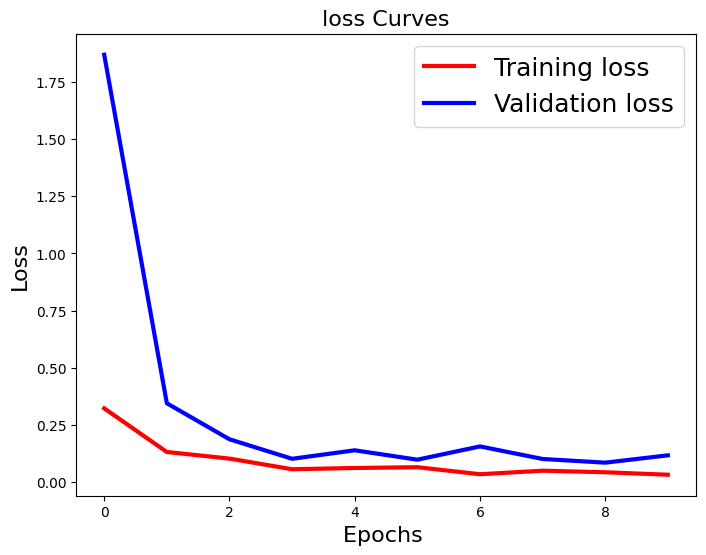

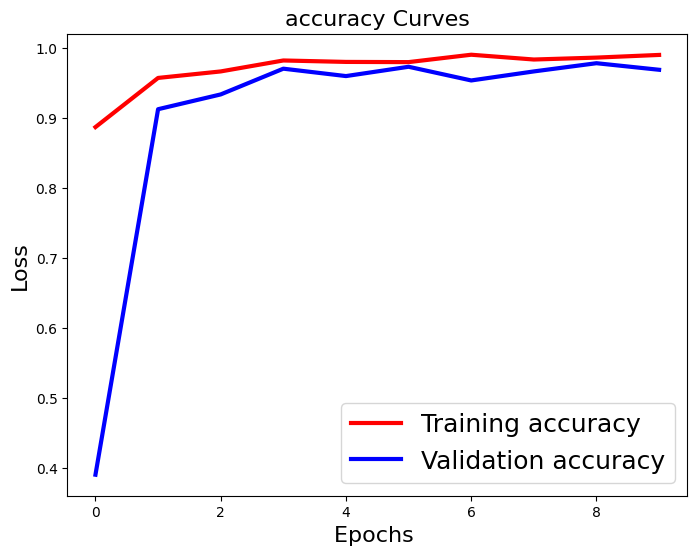

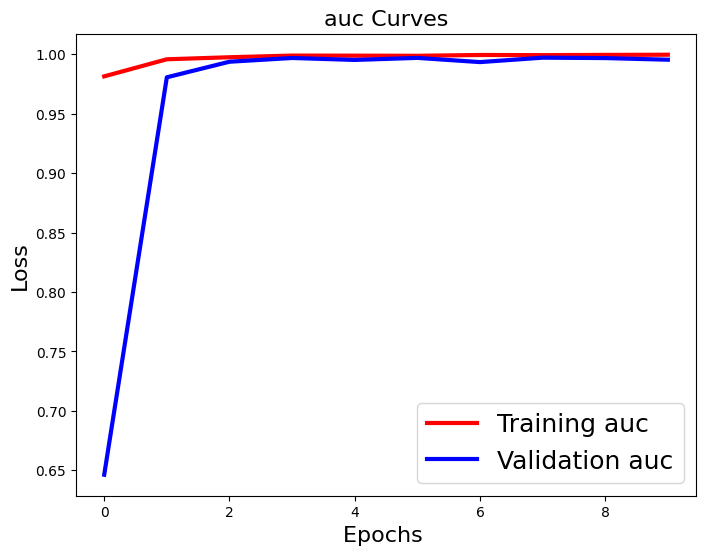

In [15]:
def plot(metric):
    plt.figure(figsize=[8,6])
    plt.plot(history.history[metric], 'r', linewidth=3.0)
    plt.plot(history.history[f'val_{metric}'], 'b', linewidth=3.0)
    plt.legend([f'Training {metric}', f'Validation {metric}'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title(f'{metric} Curves', fontsize=16)
    plt.show()
    
plot('loss')
plot('accuracy')
plot('auc')

54/54 [==============================] - 33s 606ms/step
              precision    recall  f1-score   support

           0       1.00      0.84      0.92       399
           1       0.94      0.95      0.95       421
           2       0.92      1.00      0.96       510
           3       0.96      0.99      0.97       374

    accuracy                           0.95      1704
   macro avg       0.95      0.95      0.95      1704
weighted avg       0.95      0.95      0.95      1704



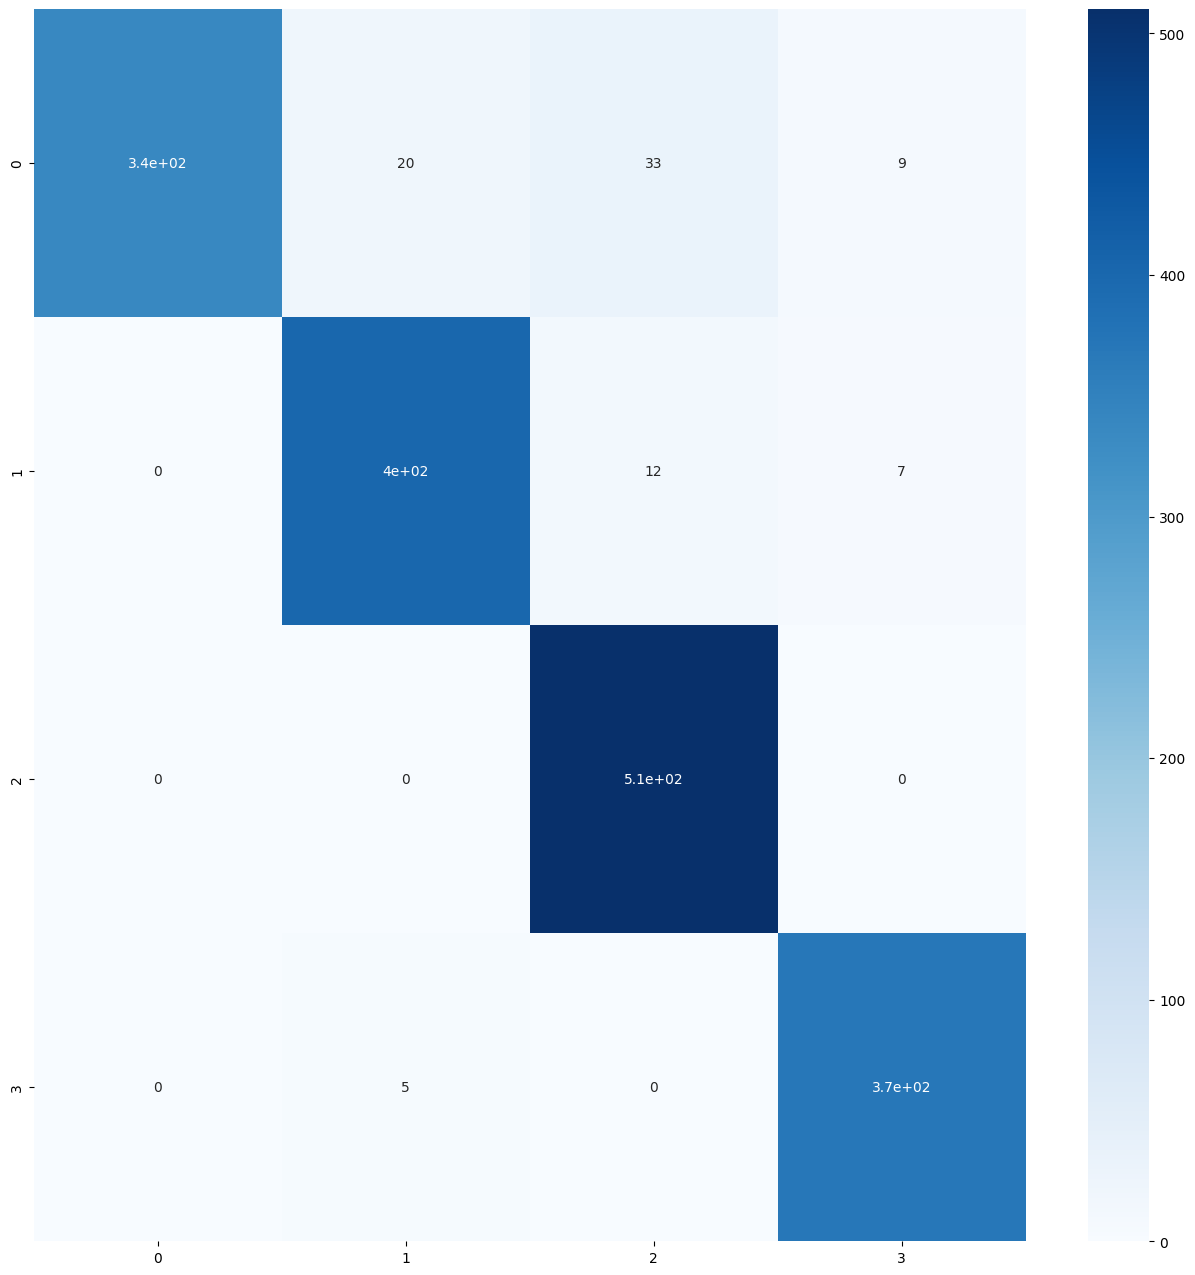

In [12]:
predicted_classes = np.argmax(model.predict(X_test), axis=1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap='Blues', annot=True, cbar=True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [13]:
loss, acc, auc = model.evaluate(X_test, y_test)

54/54 [==============================] - 34s 620ms/step - loss: 0.2515 - accuracy: 0.9495 - auc: 0.9881
